In [18]:
#load modules
from Bio import Entrez, Seq, SeqIO, pairwise2, Align, Phylo
import numpy as np
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio.Alphabet import generic_dna
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
import matplotlib
import matplotlib.pyplot as plt
import math

#load nucleotide sequences from NCBI 
def get_seq(db, key, rettype="gb"):
    Entrez.email = "A.N.Other@example.com"
    handle = Entrez.efetch(db=db, id=key, rettype=rettype)
    return SeqIO.read(handle, "gb")

## Call NCBI API

In [2]:
#[welche daten werden geladen?]
#hvr-1
nea_1a = get_seq("nucleotide", "AF011222")
nea_1b = get_seq("nucleotide", "AF282971")

#[welche daten werden geladen?]
#hvr-2
nea_2a = get_seq("nucleotide", "AF142095")
nea_2b = get_seq("nucleotide", "AF282972")

In [3]:
n = 206 #known length

nea_1 = nea_1a.seq + nea_2a.seq
nea_2 = nea_1b.seq + nea_2b.seq

# Trim sequences with local alignment

In [4]:
nea_1_algn = []
sequences = []
tmp_sequences = []
starts = []
ends = []
span = []
human_ids = []
with open("d_loop.fasta", "r") as handle:
    d_loop = list(SeqIO.parse(handle, "fasta"))
    for a in d_loop:
        sequences.append(a)
        human_ids.append(a.id)
    for i in range(202):
        if i%2 == 0:
            print("|", end="")
        alignment = pairwise2.align.localms(sequences[i].seq, nea_1, 5, -4, -8, -8)
        tmp_sequence = alignment[i][0]
        starts.append(alignment[i][3])
        ends.append(alignment[i][4])
        span.append(alignment[i][4]-alignment[i][3])
        tmp_sequences.append(tmp_sequence)
        nea_1_algn.append(alignment[i][1])

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

 ### Trim missing 4 Sequences from d_loop

In [5]:
sequences = []
with open("d_loop.fasta", "r") as handle:
    d_loop = list(SeqIO.parse(handle, "fasta"))
    for a in d_loop:
        sequences.append(a)
    for j in range(4):
        alignment = pairwise2.align.localms(sequences[j+202].seq, nea_1, 5, -4, -8, -8)
        tmp_sequence = alignment[j][0]
        starts.append(alignment[j][3])
        ends.append(alignment[j][4])
        span.append(alignment[j][4]-alignment[j][3])
        tmp_sequences.append(tmp_sequence)

In [6]:
trimmed_sequences = []
smallest_val = min(span)
var = span.index(smallest_val)
start = starts[var]
end = ends[var]

for l in range(len(tmp_sequences)):
    whole_sequence = tmp_sequences[l]
    trimmed_sequence = whole_sequence[start:end]
    trimmed_sequences.append(trimmed_sequence)
    

In [7]:
def trimmer(seq):
    start = 0
    var = False
    while var == False:
        if seq[start] != "-":
            var = True
        else:
            start += 1
    var = False
    end = len(seq) -1
    return seq[start:start+min(span)]
    

nea_1_trimmed = trimmer(nea_1_algn[var])
trimmed_sequences.append(nea_1_trimmed)
nea_alignment = pairwise2.align.localms(nea_1_trimmed, nea_2, 5, -4, -8, -8)
nea_2_untrimmed = nea_alignment[0][1]
nea_2_trimmed = nea_2_untrimmed[0:min(span)]
trimmed_sequences.append(nea_2_trimmed)



In [8]:
record_trimmed_list = []
for k in range(len(trimmed_sequences)-2):
    x_1 = str(k+1)
    x_2 = "human_"
    x = str(x_2 + x_1)
    record_trimmed_list.append(SeqRecord(Seq(trimmed_sequences[k], generic_dna), id= x))
for j in range(len(trimmed_sequences)-2, len(trimmed_sequences)):
    x_1 = str(j-len(trimmed_sequences)+3)
    x_2 = "nea_"
    x = str(x_2 + x_1)
    record_trimmed_list.append(SeqRecord(Seq(trimmed_sequences[k], generic_dna), id= x))
with open("alignment_w_nea.fasta", "w") as output_handle:
    SeqIO.write(record_trimmed_list, output_handle, "fasta")


In [9]:
human_ids.append("nea_1")
human_ids.append("nea_2")

In [10]:
record_trimmed_list = []
for k in range(len(trimmed_sequences)):
    record_trimmed_list.append(SeqRecord(Seq(trimmed_sequences[k], generic_dna), id=human_ids[k]))
align = MultipleSeqAlignment(record_trimmed_list)
calculator = DistanceCalculator('identity')
d = calculator.get_distance(align)

In [34]:
constructor = DistanceTreeConstructor()
n_tree = constructor.upgma(d)

In [36]:
Phylo.draw_ascii(n_tree)

             , nea_2
  ___________|
 |           | nea_1
 |
 |             ____ Tonga(AY289102).txt
 |          __|
 |         |  |____ PNGCoast(AY289076).txt
 | ________|
 ||        |   ____ Tuvan(AY519495).txt
 ||        |__|
 ||           |____ Cook(AY289068).txt
 ||
 ||               , Samoa(AY289093).txt
 ||               |
 ||      _________| PNGCoast(AY289080).txt
 ||     |         |
 ||    _|         | PNGCoast(AY289077).txt
 ||   | |
 ||   | |_________ Chinese(AF346972).txt
 ||   |
 ||   |        _______ Mbuti(AF346999).txt
 ||   |       |
 ||   |       |      __ San(AF347008).txt
 ||   |     __|    _|
 ||   |    |  |  ,| |__ PNGCoast(AY289081).txt
 ||   |    |  |  ||
 ||   |    |  |  ||____ Leon(AF382007).txt
 ||   |    |  |__|
 ||   |    |     |     , Navajo(AY195787).txt
 ||   |    |     |  ___|
 ||   |    |     |_|   | Leon(AF382006).txt
 ||   | ___|       |
 ||   ||   |       |___ Khwe(AY195777).txt
 ||   ||   |
_||   ||   |             , PNGHigh(AY289090).txt
 ||   ||   

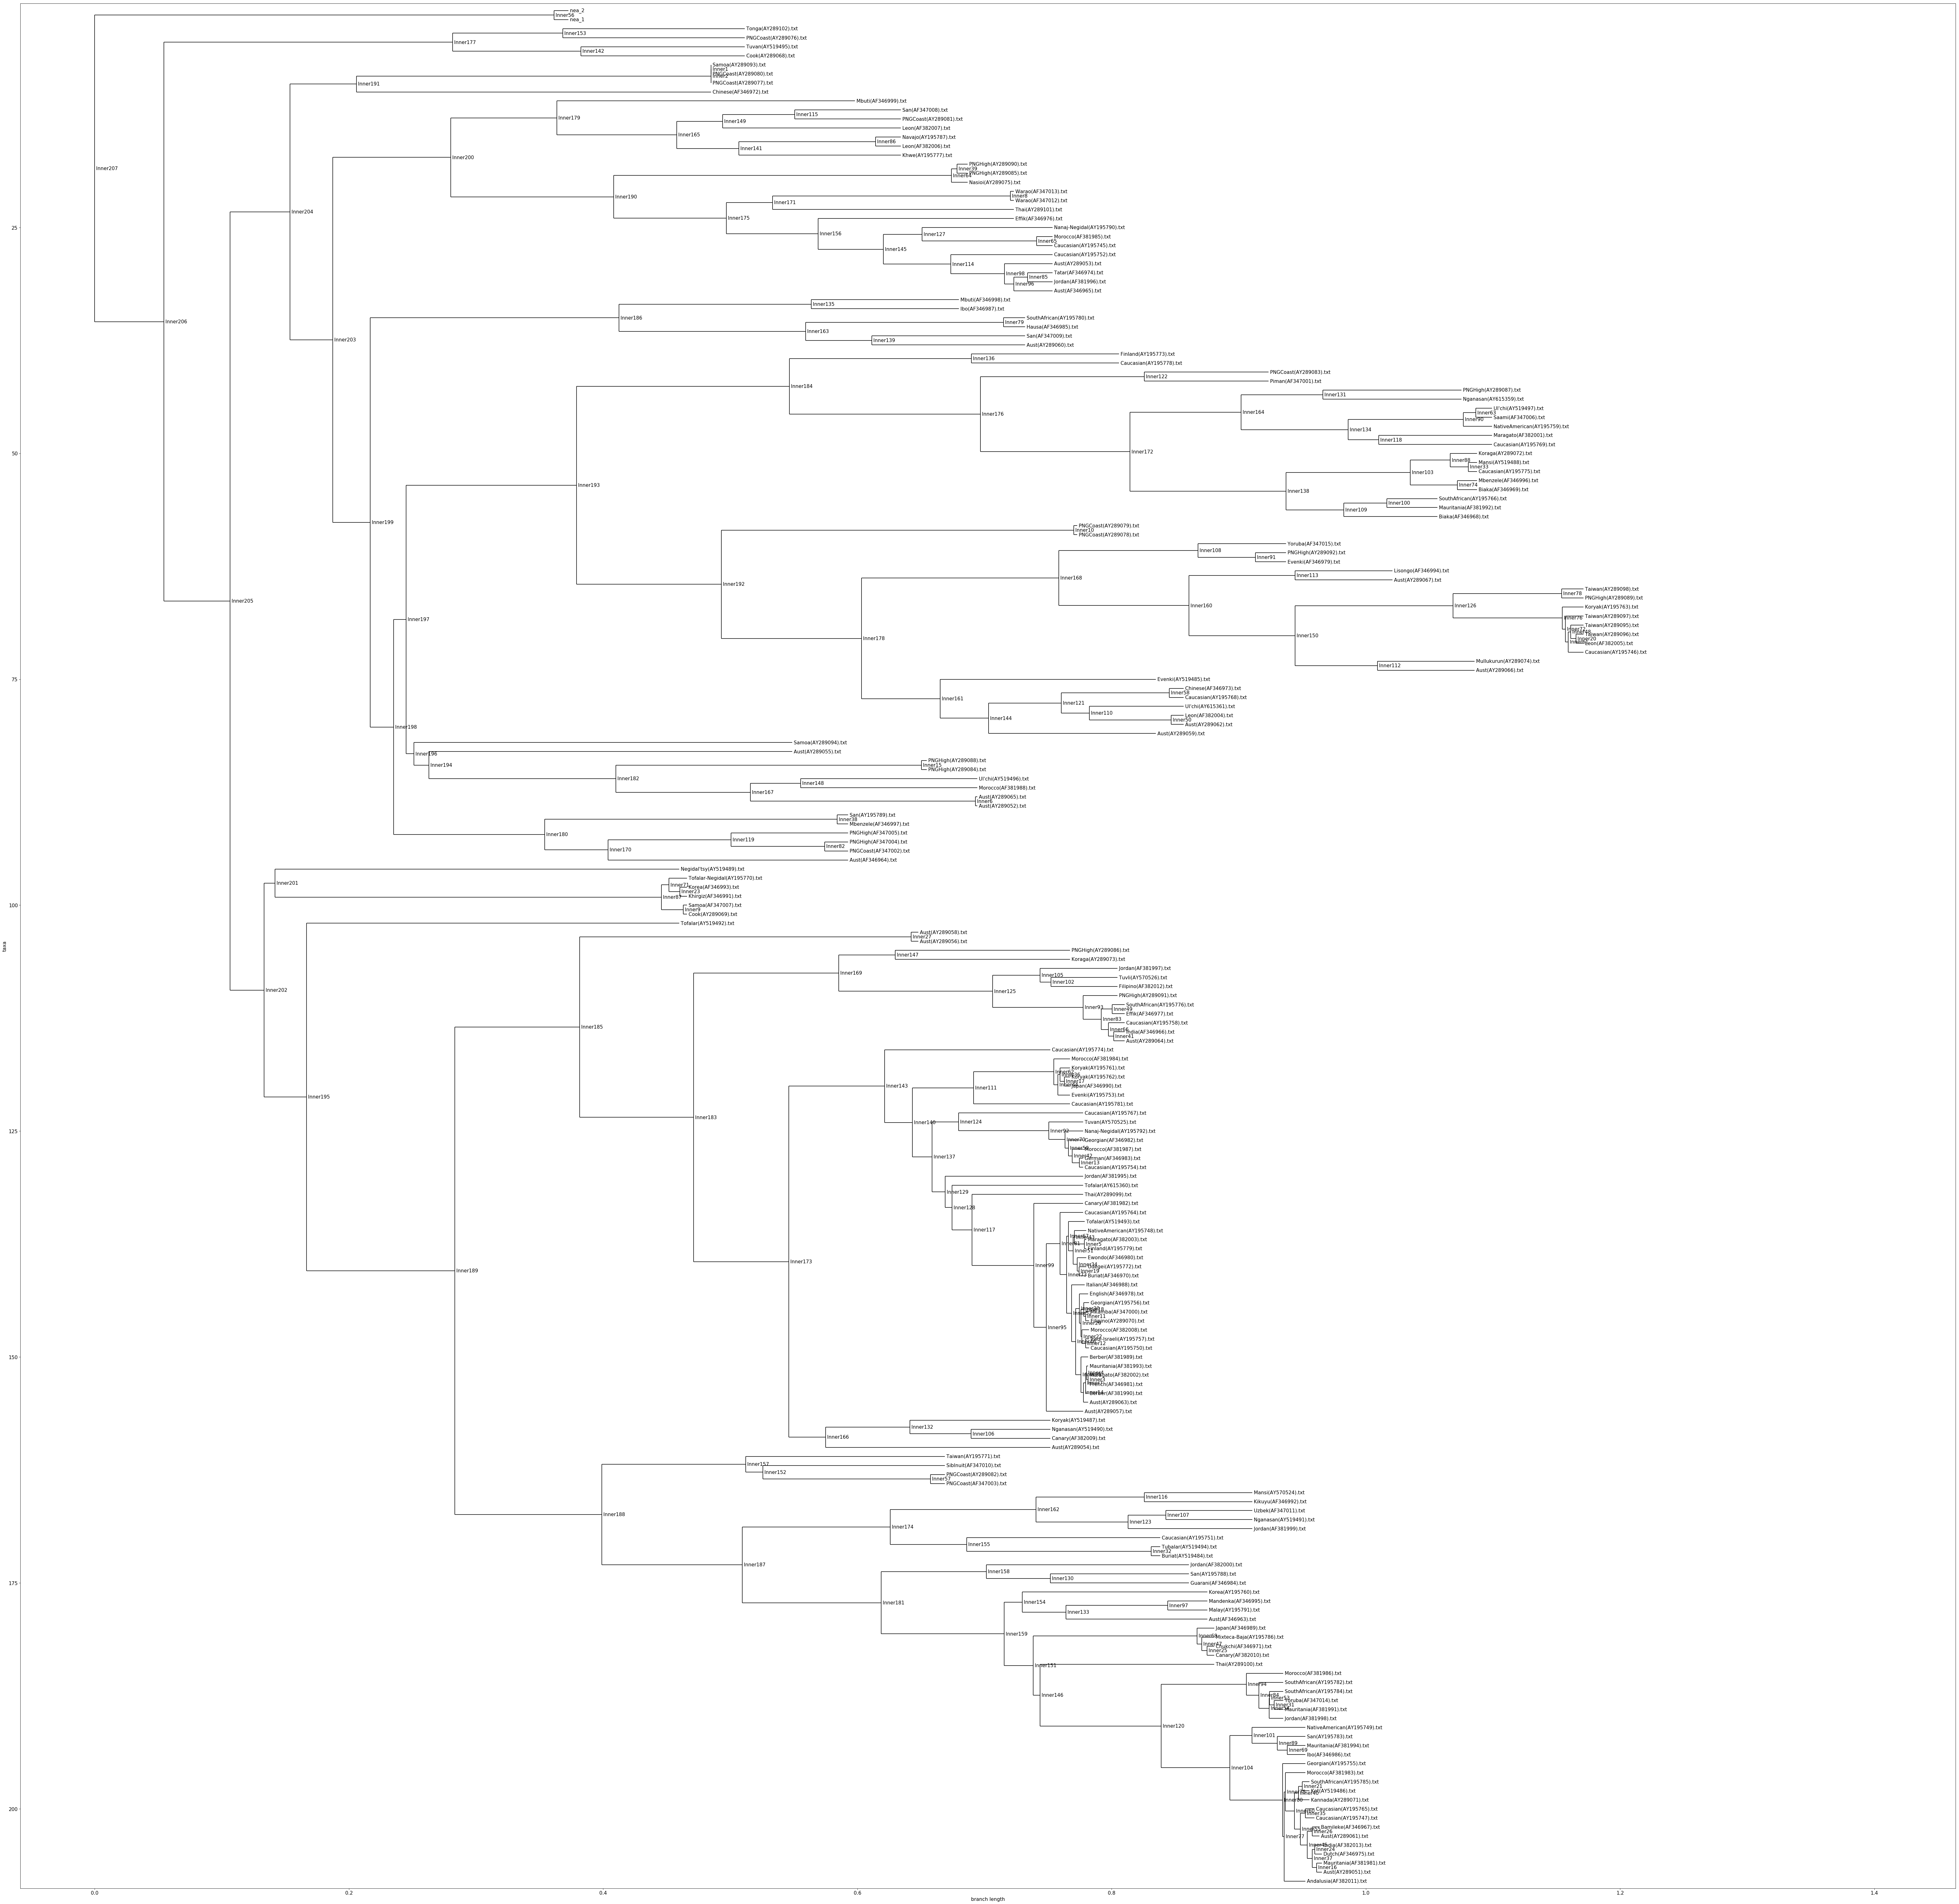

In [35]:
matplotlib.rc('font', size=14)
fig = plt.figure(figsize=(100, 100), dpi=80)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(n_tree, axes=axes)

# Primate evolution

In [37]:
human_primates_sequences = []
with open("human_primates_hvr_2.fasta", "r") as handle:
    human_primates = list(SeqIO.parse(handle, "fasta"))
    for a in human_primates:
        human_primates_sequences.append(a)

def remove_gaps(seq):
    new_seq_list = []
    for i in range(len(seq)):
        if seq[i] == "-":
            pass
        else:
            new_seq_list.append(seq[i])
    return "".join(new_seq_list)

x = remove_gaps(human_primates_sequences[-1])
human_primates_sequences[-1].seq = Seq(x[0:len(x)-8])

mult_human_primates_sequences = MultipleSeqAlignment(human_primates_sequences)
distances = calculator.get_distance(mult_human_primates_sequences)


In [61]:
def jukes_cantor(d):
    for i in range(len(d)):
        for j in range(len(d[i])):
            if d[i][j] > 3/4:
                print(d[i][j])
    return d
jukes_cantor(distances)

0.7626112759643917
0.7626112759643917
0.7655786350148368
0.7655786350148368
0.7566765578635015
0.7566765578635015
0.7596439169139466
0.7596439169139466
0.7566765578635015
0.7566765578635015
0.7626112759643917
0.7655786350148368
0.7566765578635015
0.7596439169139466
0.7566765578635015
0.7626112759643917
0.7655786350148368
0.7566765578635015
0.7596439169139466
0.7566765578635015


DistanceMatrix(names=['Berber', 'Chinese', 'Georgian', 'Yoruba', 'Pan_troglodytes_1', 'Pan_troglodytes_2', 'Pan_troglodytes_3', 'Pan_paniscus_1', 'Pan_paniscus_2', 'Gorilla_gorilla_1', 'Gorilla_gorilla_2', 'Gorilla_gorilla_gorilla', 'Pongo_pygmaeus_abelii_1', 'Pongo_pygmaeus_abelii_2', 'Pongo_pygmaeus_1', 'Pongo_pygmaeus_2', 'Hylobates_lar', 'Neanderthal'], matrix=[[0], [0.011869436201780381, 0], [0.1602373887240356, 0.1572700296735905, 0], [0.005934718100890191, 0.011869436201780381, 0.1602373887240356, 0], [0.24925816023738867, 0.24925816023738867, 0.255192878338279, 0.24332344213649848, 0], [0.24925816023738867, 0.24925816023738867, 0.255192878338279, 0.24332344213649848, 0.0, 0], [0.287833827893175, 0.287833827893175, 0.2937685459940653, 0.287833827893175, 0.24332344213649848, 0.24332344213649848, 0], [0.35014836795252224, 0.35608308605341243, 0.35905044510385753, 0.35608308605341243, 0.3175074183976261, 0.3175074183976261, 0.3798219584569733, 0], [0.35014836795252224, 0.3560830860

In [38]:
primates_tree = constructor.upgma(distances)

In [39]:
Phylo.draw_ascii(primates_tree)


          ______________________ Hylobates_lar
         |
  _______|                                          , Pongo_pygmaeus_2
 |       |                       ___________________|
 |       |                      |                   | Pongo_pygmaeus_1
 |       |______________________|
 |                              |                   , Pongo_pygmaeus_abelii_2
 |                              |___________________|
_|                                                  | Pongo_pygmaeus_abelii_1
 |
 |                                        , Gorilla_gorilla_2
 |           _____________________________|
 |          |                             | Gorilla_gorilla_1
 |          |
 |__________|           __________________ Gorilla_gorilla_gorilla
            |          |
            |          |                       , Pan_paniscus_2
            |__________|        _______________|
                       |       |               | Pan_paniscus_1
                       |       |
               

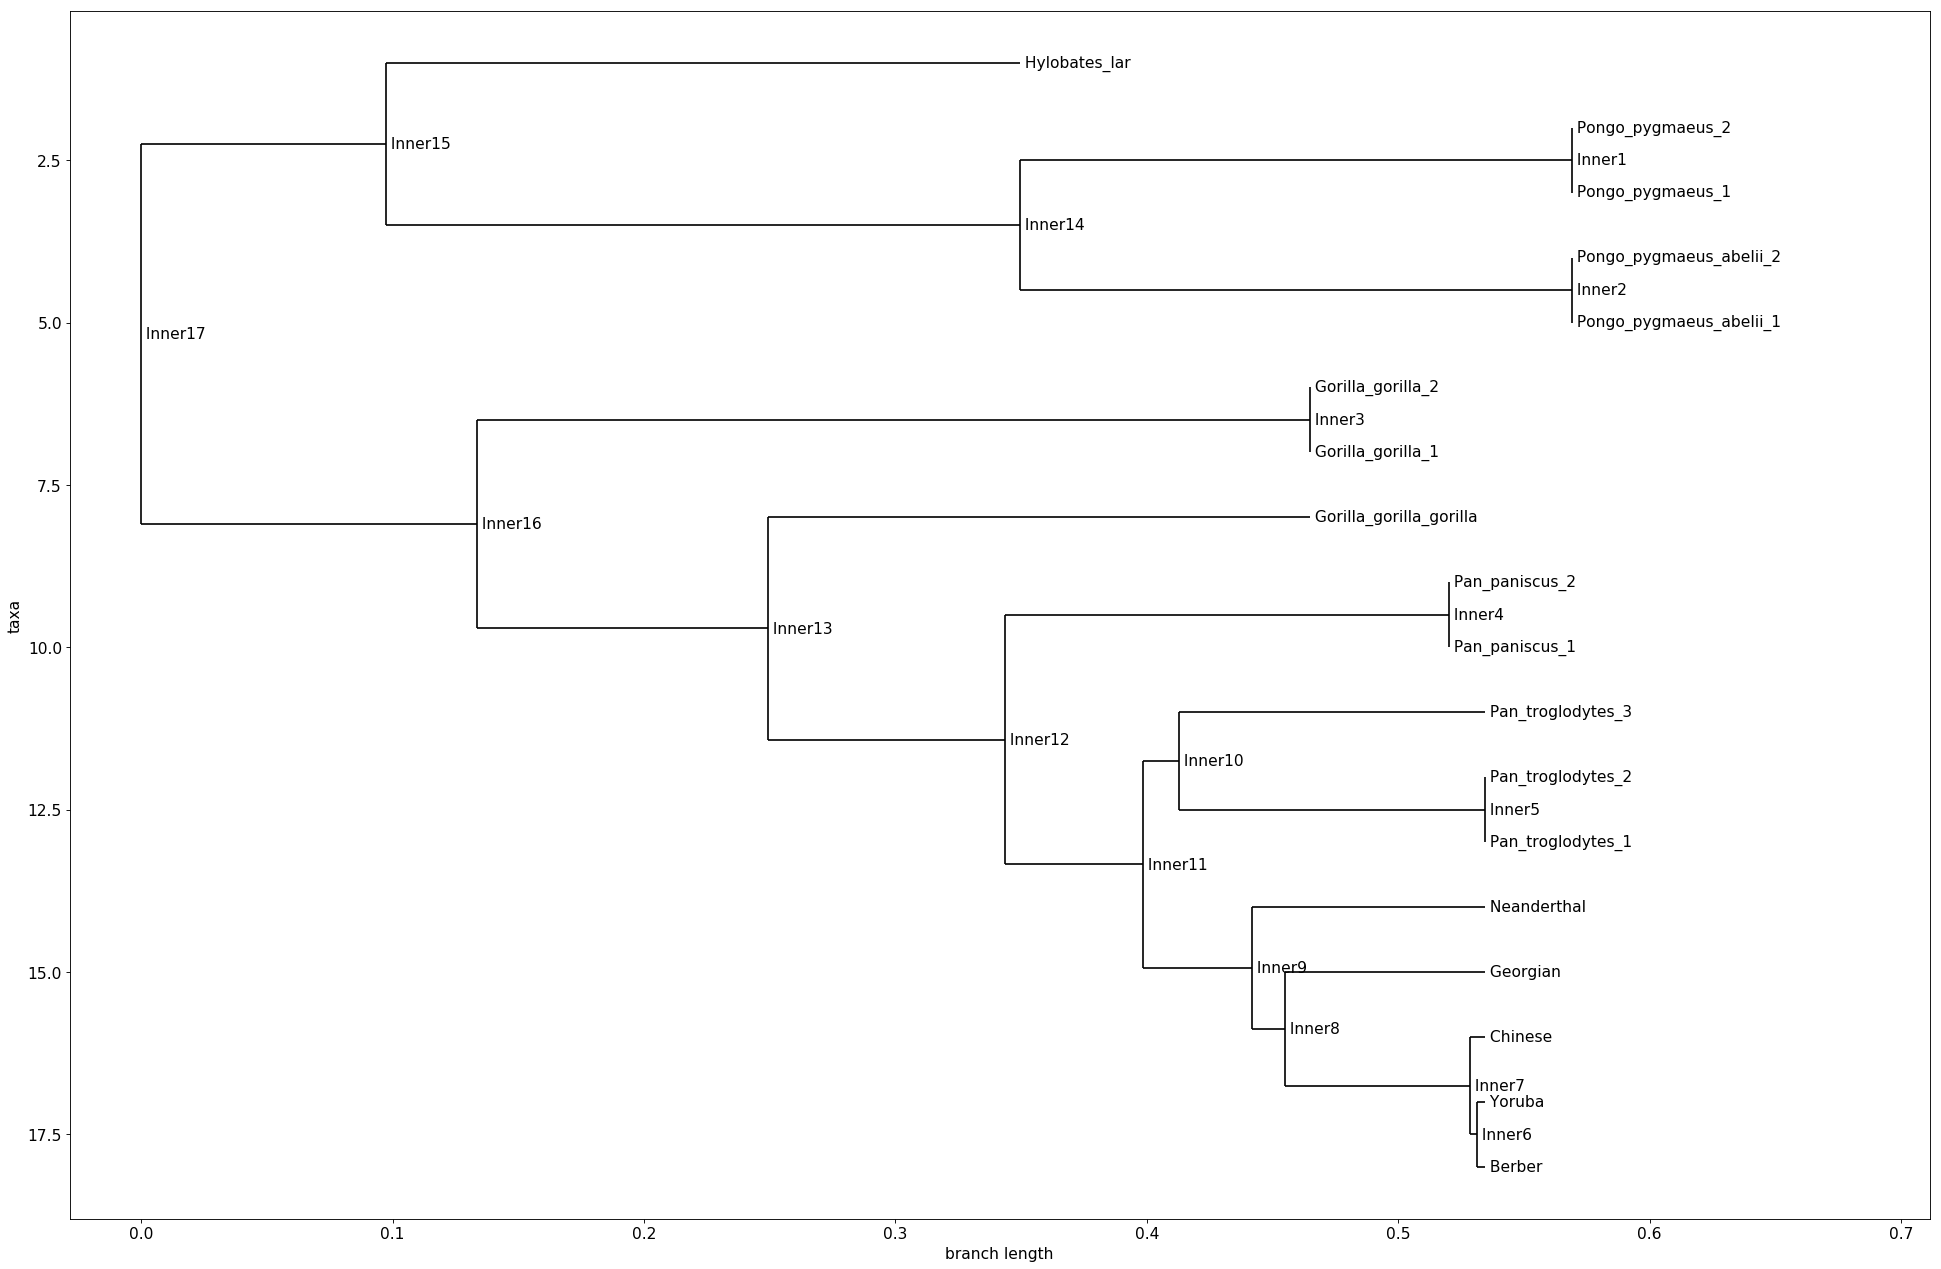

In [38]:

matplotlib.rc('font', size=14)
fig = plt.figure(figsize=(30, 20), dpi=80)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(primates_tree, axes=axes)